In [1]:
# Import Statements


%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboardX import SummaryWriter
from datetime import datetime
import importlib


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
color = sns.color_palette()


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
num_classes=5


#from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

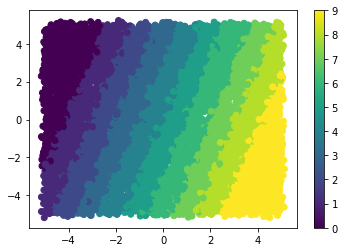

In [2]:
num_classes = 10
dim = 2

def generateLinearData(num_samples = 10000, num_classes = num_classes, dim = dim, bound = 5, sigma_noise = .1,rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
        
    fvec = np.random.rand(dim, num_samples)*bound*2-bound
    label = np.dot((np.random.rand(1,dim)*bound*2-bound).reshape(1,-1),fvec)

    sorted_idx = np.argsort(label)
    bin_size = label.shape[1]/num_classes

    for k in range(0, num_classes):
        label[0, sorted_idx[0, np.floor(k*bin_size).astype(int):np.floor((k+1)*bin_size).astype(int)]] = rand_classes[k]

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

fvec, label = generateLinearData(rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label)
plt.colorbar()


In [ ]:
def generateCircularData(num_samples = 10000, num_classes = num_classes, dim = dim,
                         bound = 5, sigma_noise = .1, rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
        
    fvec = np.random.rand(dim, num_samples)*bound*2-bound
    
    fvec_l = np.sum(fvec**2, axis = 0).reshape(1,-1)
    print(fvec_l.shape)
    label = fvec_l

    sorted_idx = np.argsort(label)
    bin_size = label.shape[1]/num_classes

    for k in range(0, num_classes):
        label[0, sorted_idx[0, np.floor(k*bin_size).astype(int):np.floor((k+1)*bin_size).astype(int)]] = rand_classes[k]

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

fvec, label = generateCircularData(num_classes =5, sigma_noise = 0, rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Greys'))


In [ ]:
def generateSpiralData(num_samples = 10000, num_classes = 9, dim = 2,
                         bound = 1, sigma_noise = .1, rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
    
    #rand_classes = [1, 1.5, -1, -1.5]
    sample_per_class = int(num_samples/num_classes)
    num_samples = sample_per_class*num_classes
    fvec = np.zeros((dim, sample_per_class*num_classes))
    label = np.zeros((1, sample_per_class*num_classes))
    
    t = np.linspace(0, 10, sample_per_class)
    x = t * np.cos(t)
    y = t * np.sin(t)
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)

    cons = .7
    for k in range(0, num_classes):
        r = np.linspace(0.05, 1, sample_per_class)
        t = np.linspace(k*cons, (k+6)*cons, sample_per_class)
        x = np.cos(t)
        y = np.sin(t)
        x = x.reshape(1, -1)
        y = y.reshape(1, -1)
        label[0, k*sample_per_class:(k+1)*sample_per_class] = rand_classes[k]
        fvec[0, k*sample_per_class:(k+1)*sample_per_class] = bound * x * r
        fvec[1, k*sample_per_class:(k+1)*sample_per_class] = bound * y * r

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

plt.figure(figsize=(15,7))
X, y = generateSpiralData(num_classes = 9, sigma_noise = 0.01, rand_label = False)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = plt.get_cmap('Set1'))
plt.colorbar()

In [ ]:
def generateSpiralData(num_samples = 10000, num_classes = num_classes, dim = dim,
                         bound = 5, sigma_noise = .1, rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
    
    #rand_classes = [1, 1.5, -1, -1.5]

    cons = 4
    N = num_samples # number of points per class
    D = dim # dimensionality
    K = num_classes # number of classes

    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*sigma_noise # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = j
    
    label = y.astype(np.int)
    fvec = X
    
    return fvec, label

plt.figure(figsize=(15,7))
plt.subplot(121)
fvec, label = generateCircularData(num_classes =9, sigma_noise = 0, rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Set1'))
plt.colorbar()
plt.subplot(122)
fvec, label = generateSpiralData(num_classes = 3, sigma_noise = 0, rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Set1'))
plt.colorbar()
#plt.savefig('circular_vs_spiral.tiff')

# Ordinal Regression Benchmark Datasets

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
num_bins=10

In [3]:
from subprocess import check_output
print(check_output(["ls", "./dataset/regression"]).decode("utf8"))

bank32nh.data
bank8FM.data
bostonhousing
cal_housing.data
cpu_act.data
cpu_small.data
house_16H.data
house_8L.data
housing
results.csv
stock
stocksdomain



In [4]:
train_df = pd.read_csv("./dataset/regression/housing", sep=',', header=None)
train_df=train_df.drop(train_df.columns[-1],axis=1)
print(train_df.shape)

columns=["feat"+str(k) for k in range(train_df.shape[1])]
columns[-1]="label"
train_df.columns=columns

train_df.shape

(506, 0)


IndexError: list assignment index out of range

In [4]:
train_df = pd.read_csv("./dataset/regression/house_16H.data", sep=',', header=None)
#train_df=train_df.drop(train_df.columns[-1],axis=1)

columns=["feat"+str(k) for k in range(train_df.shape[1])]
columns[-1]="label"
train_df.columns=columns

train_df.shape

(22784, 17)

In [5]:
train_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,label
0,15512.0,0.460869,0.049252,0.226470,0.149827,0.752837,0.010057,0.579729,0.003251,0.075912,0.625318,0.036613,0.991377,0.260116,0.052246,0.774059,130600.0
1,1550.0,0.470968,0.002581,0.137419,0.096341,0.862581,0.000000,0.695142,0.005025,0.043551,0.064263,0.003350,0.994975,0.285266,0.060606,0.142857,40500.0
2,4741.0,0.485341,0.000211,0.189412,0.135656,0.856992,0.000000,0.683584,0.004143,0.027965,0.065796,0.000000,0.997411,0.315433,0.065116,0.687500,28700.0
3,467.0,0.498929,0.000000,0.100642,0.085470,0.907923,0.000000,0.780488,0.006098,0.018293,0.057471,0.000000,1.000000,0.149425,0.139535,1.000000,28500.0
4,310.0,0.474194,0.680645,0.225806,0.128834,0.896774,0.000000,0.756302,0.008403,0.016807,0.077519,0.672269,0.991597,0.147287,0.000000,0.000000,24100.0


Number of Samples per class is 2278.4
[0.0, 14999.000099999999, 18400.000199999999, 23400.0003, 28100.000400000001, 33200.000500000002, 39800.000599999999, 49600.000699999997, 65300.000800000002, 102600.0009, 500001.00099999999]
[0.0, 14999.000099999999, 18400.000199999999, 23400.0003, 28100.000400000001, 33200.000500000002, 39800.000599999999, 49600.000699999997, 65300.000800000002, 102600.0009, 500002.00099999999]
500001.0
Unique labels are [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


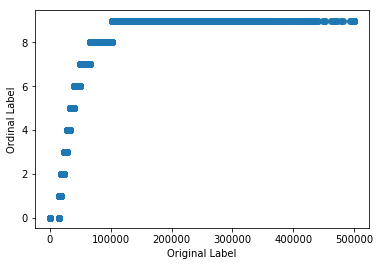

In [6]:
#train_df['label_ord']=train_df['label']
label=train_df.label.values
sorted_idx=np.argsort(train_df.label.values)
num_samples_per_class=train_df.shape[0]/num_bins
print('Number of Samples per class is ' + str(num_samples_per_class))
bins=[(k*1e-4+label[sorted_idx[np.round(k*num_samples_per_class-1).astype(np.int)]]) for k in range(1,num_bins+1)]
bins.insert(0,0.0)
print(bins)
bins[-1]=bins[-1]+1
print(bins)

label_ord=label.copy()
k = 10

print(label[sorted_idx[np.round(k*num_samples_per_class-1).astype(np.int)]])
for k in range(num_bins):
    #print(np.all([label>=bins[k], label<bins[k+1]],0))
    label_ord[np.all([label>=bins[k], label<bins[k+1]],0)]=k
    
print('Unique labels are ' + str(np.unique(label_ord)))


train_df['label_ord']=label_ord
#print(train_df.head())

plt.scatter(label,label_ord)
plt.xlabel('Original Label')
plt.ylabel('Ordinal Label')
plt.show()


In [7]:
train_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,label,label_ord
0,15512.0,0.460869,0.049252,0.226470,0.149827,0.752837,0.010057,0.579729,0.003251,0.075912,0.625318,0.036613,0.991377,0.260116,0.052246,0.774059,130600.0,9.0
1,1550.0,0.470968,0.002581,0.137419,0.096341,0.862581,0.000000,0.695142,0.005025,0.043551,0.064263,0.003350,0.994975,0.285266,0.060606,0.142857,40500.0,6.0
2,4741.0,0.485341,0.000211,0.189412,0.135656,0.856992,0.000000,0.683584,0.004143,0.027965,0.065796,0.000000,0.997411,0.315433,0.065116,0.687500,28700.0,4.0
3,467.0,0.498929,0.000000,0.100642,0.085470,0.907923,0.000000,0.780488,0.006098,0.018293,0.057471,0.000000,1.000000,0.149425,0.139535,1.000000,28500.0,4.0
4,310.0,0.474194,0.680645,0.225806,0.128834,0.896774,0.000000,0.756302,0.008403,0.016807,0.077519,0.672269,0.991597,0.147287,0.000000,0.000000,24100.0,3.0


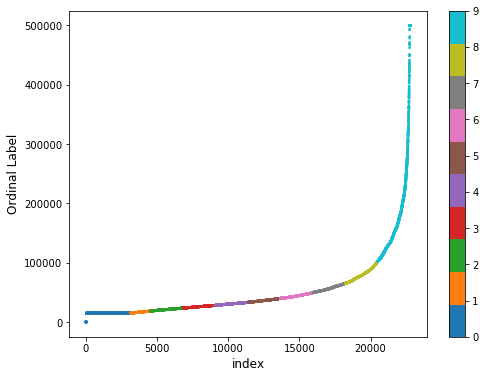

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), label[sorted_idx],s=3,
            c=np.sort(label_ord[sorted_idx]), cmap = plt.get_cmap('tab10'))
plt.colorbar()
plt.xlabel('index', fontsize=12)
plt.ylabel('Ordinal Label', fontsize=12)

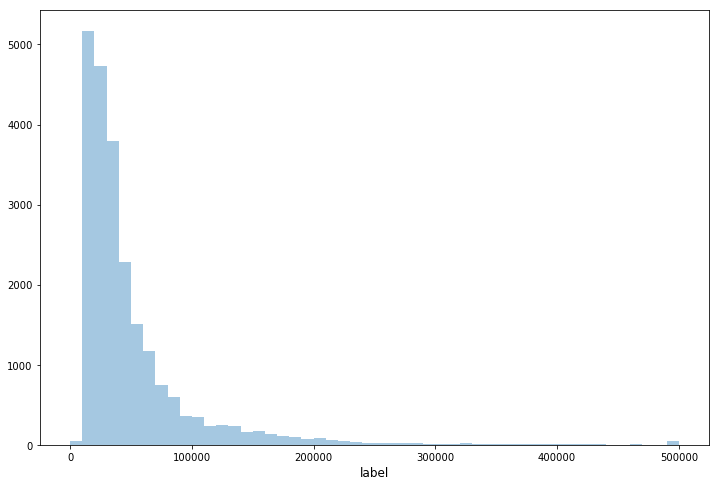

In [9]:
'''ulimit = np.percentile(train_df.label.values, 98)
llimit = np.percentile(train_df.label.values, 2)
train_df['label'].ix[train_df['label']>ulimit] = ulimit
train_df['label'].ix[train_df['label']<llimit] = llimit'''

plt.figure(figsize=(12,8))
sns.distplot(train_df.label.values, bins=50, kde=False)
plt.xlabel('label', fontsize=12)


# Train an MLP network

In [10]:
def make_coeff(n, metric, lmbda = 1):
    if metric is 'ccr':
        return [1]
    elif metric is 'ccr1':
        return [1, 1, 1]
    elif metric is 'mae':
        coeff = np.arange(1,n)/(n-1)
    elif metric is 'mse':
        coeff = np.zeros(n-1)
        coeff[0] = 2*n-3
        for k in range(1, n-1):
            coeff[k] = coeff[k-1] + 2*n - (2*(k+1)+1)
        coeff = coeff /((n-1)**2)
    else:
        print('Undefined Metric: ' + metric)
    coeff = np.concatenate((coeff, coeff[::-1][1:]), axis=0)
    coeff = coeff * lmbda
    coeff[n-2] = 1
    return coeff

In [11]:
data_type = 'house_16H'
num_samples = 10000
num_classes = 9
nclasses = num_classes
dim = 2

sigma_noise = 0.01
optimizer='sgd' #Optimizer function
iter_loc=10 #Number of the first column in the excel file for writing the results.
lr=.5 #Initial learning rate
momentum=0.9
weight_decay=0.0005
batch_size = 256
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay
hidden_sizes = [50, 50]
dropouts = [0, 0]
rand_label = False

metric = 'ccr'
coeff_lmbda =  1
multi_coeff = make_coeff(nclasses, metric, coeff_lmbda)
KL = False #KL divergence for porbability measure


'''Multipliers for loss functions'''
single_loss=1.
multi_loss=0.

comment=' ' #Additional comments if any

algo = None



In [12]:
CV = 5
random_seed = 1

if data_type == 'circular':
    fvec, label = generateCircularData(num_samples = num_samples, 
                                       num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
elif data_type == 'linear':
    fvec, label = generateLinearData(num_samples = num_samples, 
                                     num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
elif data_type == 'spiral':
    fvec, label = generateSpiralData(num_samples = num_samples, 
                                     num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
else:
    num_classes = num_bins
    nclasses = num_classes
    
    feat=train_df.values[:,:-2]
    #Normalize the features

    feat_max = np.amax(feat,axis=0)
    feat_min = np.amin(feat,axis=0)

    feat=(feat-feat_min)/(feat_max-feat_min)
    feat=feat*2-1

    '''feat_mean = np.mean(feat,axis=0)
    feat_std = np.std(feat,axis=0)

    feat=(feat-feat_mean)/feat_std
    '''
    label_ord=train_df.values[:,-1].astype(np.int)

    rand_idx = np.random.permutation(len(label_ord))
    feat = feat[rand_idx, :]
    label = label_ord[rand_idx]


    print(np.mean(feat,axis=0))
    print(np.min(feat,axis=0))
    print(feat.shape)
    print(label)

    fvec=feat.copy()
    dim = feat.shape[1]
    
    if not CV == 0: 
        dset_train= torch.utils.data.TensorDataset(torch.from_numpy(fvec).type(torch.FloatTensor),
                                                       torch.from_numpy(label).type(torch.LongTensor))
        dset_val= torch.utils.data.TensorDataset(torch.from_numpy(fvec).type(torch.FloatTensor),
                                                       torch.from_numpy(label).type(torch.LongTensor))

        '''Define dataset loaders''''''
        dset_loaders = {'train':torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size,shuffle=True,
                                                            num_workers=12),
                        'val':torch.utils.data.DataLoader(dsets['val'], batch_size=batch_size,shuffle=False,
                                                            num_workers=12)}


        dset_sizes={'train':len(dsets['train']),'val':len(dsets['val'])}
        use_gpu = torch.cuda.is_available()

        print(dset_sizes)

        if use_gpu:
            print('GPU is available')
        else:
            print('!!!!! NO CUDA GPUS DETECTED')

        inputs, classes = next(iter(dset_loaders['train']))
        print(inputs.shape)'''
        '''dset_train = datasets.ImageFolder(data_dir+'/train_val', data_transforms['train'])
        dset_val = datasets.ImageFolder(data_dir+'/train_val', data_transforms['val'])'''

        num_train = len(dset_train)
        indices = list(range(num_train))
        np.random.seed(random_seed)
        np.random.shuffle(indices)

        splits = (num_train*np.linspace(0,1,CV+1)).astype(int)

        val_idx = [indices[splits[k]:splits[k+1]] for k in range(CV)]
        train_idx=[np.setdiff1d(indices,val_idx[k]) for k in range(CV)]
        '''Sampler functions for validation and training'''
        sampler_train = [torch.utils.data.sampler.SubsetRandomSampler(train_idx[k]) for k in range(CV)]
        sampler_val = [torch.utils.data.sampler.SubsetRandomSampler(val_idx[k]) for k in range(CV)]

        '''Define dataset loaders'''
        dset_loaders_arr = [{'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,sampler=sampler_train[k],
                                                            num_workers=12),
                        'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,sampler=sampler_val[k],
                                                            num_workers=12)} for k in range(CV)]
        dset_sizes={'train':int(len(dset_train)*(1-1/CV)),'val':int(len(dset_train)*(1/CV))}

        print(dset_sizes)
        print('OR')
        print('Number of training images '+str(len(val_idx)))
        print('Number of validation images '+str(len(train_idx)))
    


'''rand_idx = np.random.permutation(len(label))
fvec_norm = (fvec)/5
mid_point = int(len(label)/2)#100*num_classes
fvec_test = fvec_norm[rand_idx[:mid_point],:]
fvec_train = fvec_norm[rand_idx[mid_point:],:]

label_test = label[rand_idx[:mid_point]]
label_train = label[rand_idx[mid_point:]]
print(np.max(fvec_train))
print(np.min(fvec_train))

torch.from_numpy(label_train).type(torch.LongTensor)
dsets={'train': torch.utils.data.TensorDataset(torch.from_numpy(fvec_train).type(torch.FloatTensor),
                                               torch.from_numpy(label_train).type(torch.LongTensor)),
       'val': torch.utils.data.TensorDataset(torch.from_numpy(fvec_test).type(torch.FloatTensor),
                                             torch.from_numpy(label_test).type(torch.LongTensor))}

''''''
dset_loaders = {'train':torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size,shuffle=True,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dsets['val'], batch_size=batch_size,shuffle=False,
                                                    num_workers=12)}


dset_sizes={'train':len(dsets['train']),'val':len(dsets['val'])}
'''
use_gpu = torch.cuda.is_available()

print(dset_sizes)

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

'''inputs, classes = next(iter(dset_loaders['train']))
print(inputs.shape)'''


[-0.99786778 -0.1046049  -0.87203641 -0.64262862 -0.52512336  0.68509746
 -0.95656432  0.25911488 -0.94257411 -0.90573663 -0.7733197  -0.88512628
  0.93387451 -0.3900144  -0.78524665 -0.01674871]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
(22784, 16)
[9 4 0 ..., 3 8 0]
{'train': 18227, 'val': 4556}
OR
Number of training images 5
Number of validation images 5
{'train': 18227, 'val': 4556}
GPU is available


"inputs, classes = next(iter(dset_loaders['train']))\nprint(inputs.shape)"

In [ ]:
print(feat.astype(np.float))

In [13]:
def writeLog(logname):
    '''
    Creates a text file named Network_properties.txt inside runs/'logname'
    '''
    f=open('runs_regression/'+logname+'/Network_properties.txt','w')
    f.write('Feature Length: '+str(dim)+'\n')
    f.write('Number of classes: '+str(num_classes)+'\n')
    f.write('Data type: '+data_type+'\n')
    f.write('Random Noise: '+str(sigma_noise)+'\n')
    
    f.write('Hidden sizes: '+ str(hidden_sizes)+'\n')
    f.write('Dropouts: '+str(dropouts)+'\n')
    f.write('Batch size: '+str(batch_size)+'\n')
    f.write('Number of samples: '+str(num_samples)+'\n')
    
    f.write('Optimizer: ' + optimizer + '\n')
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    f.write('Criterion: '+crt+'\n')
    f.write('Learning rate: '+str(lr)+'\n')
    f.write('Momentum: '+str(momentum)+'\n')
    f.write('Leraning Rate Scheduler: '+str(lr_scheduler)+'\n')
    f.write('Leraning Rate Decay Period: '+str(lr_decay_epoch)+'\n')
    f.close()

In [14]:
import openpyxl
import time

def writeLog_xlsx(logname='logs_regression.xlsx',iter_loc=10):
    '''
    Adds a line to logs.xlsx with the network properties and outcomes.
    :param iter_loc: First column to record the outcomes.
    '''
    
    print(logname)
    book = openpyxl.load_workbook(logname)
    sheet = book.active
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    if metric:
        m_coeff = make_coeff(nclasses, metric, coeff_lmbda)
    else:
        m_coeff = multi_coeff
    specs=(datetime.now().strftime('%B%d  %H:%M:%S'),data_type,str(hidden_sizes),str(dim),str(num_classes),
           crt, str(lr), str(m_coeff), str(KL))
    sheet.append(specs)
    current_row = sheet.max_row
    sheet.cell(row=current_row, column=iter_loc+5).value = comment
    book.save(logname)
writeLog_xlsx()

logs_regression.xlsx


In [15]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropouts, num_classes):
        super(Net, self).__init__()
        self.numHidden=len(hidden_sizes)
        setattr(self, 'fc0', nn.Linear(input_size, hidden_sizes[0]))
        setattr(self, 'relu0', nn.ReLU())
        setattr(self, 'drop0', nn.Dropout(p=dropouts[0]))
        for k in range(len(hidden_sizes)-1):
            setattr(self, 'fc'+str(k+1), nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            setattr(self, 'relu'+str(k+1), nn.ReLU())
            setattr(self, 'drop'+str(k+1), nn.Dropout(p=dropouts[k+1]))
        setattr(self, 'fc'+str(len(hidden_sizes)), nn.Linear(hidden_sizes[-1], num_classes))
    
    def forward(self, x):
        out=self.fc0(x)
        out = self.relu0(out)
        out = self.drop0(out)
        for k in range(self.numHidden-1):
            fc = getattr(self,'fc'+str(k+1))
            relu = getattr(self,'relu'+str(k+1))
            drop = getattr(self,'drop'+str(k+1))
            out = fc(out)
            out = relu(out)
            out = drop(out)
        fc = getattr(self,'fc'+str(self.numHidden))
        out = fc(out)
        return out
    
model=Net(2, [50, 50], [0, 0], 2)
print(model)

Net(
  (fc0): Linear(in_features=2, out_features=50, bias=True)
  (relu0): ReLU()
  (drop0): Dropout(p=0)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [16]:
def network_loader(comment=comment,
                    optimizer=optimizer,
                    iter_loc=iter_loc,
                    lr=lr,
                    momentum=momentum,
                    weight_decay=weight_decay,
                    lr_scheduler=lr_scheduler,
                    lr_decay_epoch=lr_decay_epoch,
                    nclasses=num_classes,
                    hidden_sizes = hidden_sizes,
                    dropouts = dropouts):
    
    '''Load the network from pytorch'''
    model_ft = Net(dim, hidden_sizes , dropouts, num_classes)

    if use_gpu:
        model_ft = model_ft.cuda()

    '''Define the optimizer function'''
    if(optimizer=='adam'):
        optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
    elif(optimizer=='sgd'):
        if(end_to_end):
            optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
    return model_ft, optimizer_ft

In [38]:
model_ft, optimizer_ft = network_loader(comment=comment, #'Tested for three rooms'
                                            optimizer=optimizer,
                                            iter_loc=iter_loc,
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay,
                                            lr_scheduler=lr_scheduler,
                                            lr_decay_epoch=lr_decay_epoch,
                                            nclasses=num_classes)
a_vec = Variable(torch.randn(10, 1), requires_grad=True)
params = optimizer_ft.param_groups
params[0]['params'].append(a_vec)
optimizer_ft.param_groups = params
print(optimizer_ft.param_groups)
#optimizer_ft.add_param_group({'params': a_vec})

[{'params': [Parameter containing:

Columns 0 to 9 
-0.0989  0.0276 -0.2002  0.2364  0.2187  0.2119 -0.1518  0.2126  0.1886  0.2376
-0.1236 -0.0579 -0.1949 -0.0178  0.1627  0.1492 -0.0042 -0.1609  0.1058 -0.0118
 0.1857  0.0867  0.0413 -0.1223 -0.0814 -0.0646 -0.0002  0.1864 -0.2206 -0.0385
-0.0685 -0.1728 -0.0526 -0.0080 -0.1281  0.1239 -0.0421 -0.1162  0.0698  0.1712
-0.0983 -0.2350  0.0183  0.2309  0.0525 -0.2041 -0.1387  0.0061 -0.1531  0.0568
 0.0293  0.2072 -0.2436  0.1574 -0.1800 -0.0822 -0.0655  0.0933  0.1481  0.2364
 0.1060 -0.1060  0.1533  0.1535  0.2004 -0.1161  0.2167  0.0250  0.2023  0.2357
 0.2167 -0.1310 -0.0959  0.2040  0.0319 -0.1085 -0.0613 -0.0487 -0.1800 -0.1431
 0.1159 -0.2102  0.2266  0.0710 -0.1200  0.0339  0.1792  0.2377 -0.1234 -0.1082
 0.0269  0.1652 -0.0606 -0.1809  0.2315  0.2342 -0.0817  0.0290  0.0692  0.1348
 0.1353 -0.0651 -0.1571 -0.0406 -0.0071  0.1899 -0.2087  0.1806 -0.2238 -0.1225
 0.0041 -0.1201 -0.1526 -0.0879  0.2117  0.0301 -0.0848  0.1570  0.2

In [17]:
def write_epochs(result_log, logname):
    print(len(result_log))

    wb_tr = openpyxl.Workbook()
    ws_tr = wb_tr.active
    wb_val = openpyxl.Workbook()
    ws_val = wb_val.active
    print(logname)

    label_arr_tr = np.zeros((100000,1))
    probs_arr_tr = np.zeros((100000, num_classes))
    label_arr_val = np.zeros((100000,1))
    probs_arr_val = np.zeros((100000, num_classes))

    prev_epoch = 0
    
    count_tr = count_val = 0
    for result in result_log:
        epoch = result[1]
        if not epoch == prev_epoch:
            label_arr_tr = label_arr_tr[:count_tr]
            probs_arr_tr = probs_arr_tr[:count_tr, :]
            label_arr_val = label_arr_val[:count_val]
            probs_arr_val = probs_arr_val[:count_val, :]
            ws_tr.append(['Epoch ' + str(prev_epoch)])
            ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
            ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_tr[1:,:].T.tolist():
                ws_tr.append(probs)
            #wb_tr.save('./runs_ord/'+logname + '/train.xlsx')
            ws_val.append(['Epoch ' + str(prev_epoch)])
            ws_val.append(label_arr_val[1:].reshape(-1).tolist())
            ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_val[1:,:].T.tolist():
                ws_val.append(probs)
    

            label_arr_tr = np.zeros((100000,1))
            probs_arr_tr = np.zeros((100000, num_classes))
            label_arr_val = np.zeros((100000,1))
            probs_arr_val = np.zeros((100000, num_classes)) 
            count_tr = count_val = 0
            prev_epoch = epoch

        label = np.asarray(result[2]).reshape(-1,1)
        scores = np.asarray(result[3])
        exp_scores = np.exp(scores - np.max(scores,axis=1).reshape(-1, 1)*np.ones(num_classes))
        probs = np.round(exp_scores/(np.sum(exp_scores,axis=1).reshape(-1, 1)*np.ones(num_classes)), decimals=2)
        if result[0] == 'train':
            label_arr_tr[count_tr:count_tr + len(label)]  = label
            probs_arr_tr[count_tr:count_tr + len(label), :] = probs
            count_tr += len(label)
        elif result[0] == 'val':
            label_arr_val[count_val:count_val + len(label)]  = label
            probs_arr_val[count_val:count_val + len(label), :] = probs
            count_val += len(label)


    
    label_arr_tr = label_arr_tr[:count_tr]
    probs_arr_tr = probs_arr_tr[:count_tr, :]
    label_arr_val = label_arr_val[:count_val]
    probs_arr_val = probs_arr_val[:count_val, :]
            
    ws_tr.append(['Epoch ' + str(epoch)])
    ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
    ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_tr[1:,:].T.tolist():
        ws_tr.append(probs)
    #wb_tr.save('./runs_ord/'+logname + '/train.xlsx')
    ws_val.append(['Epoch ' + str(epoch)])
    ws_val.append(label_arr_val[1:].reshape(-1).tolist())
    ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_val[1:,:].T.tolist():
        ws_val.append(probs)
    wb_val.save('./runs_regression/'+logname + '/val.xlsx')
    label_arr_tr = np.zeros((1,1))
    probs_arr_tr = np.zeros((1, num_classes))
    label_arr_val = np.zeros((1,1))
    probs_arr_val = np.zeros((1, num_classes))
    prev_epoch = epoch
    print('Finito')
    
    del label_arr_tr, probs_arr_tr, label_arr_val, probs_arr_val


In [28]:
importlib.reload(ft)
    
def run_network():
    '''
    Cretaes the log files and starts the training
    '''
    model_ft, optimizer_ft = network_loader(comment=comment, #'Tested for three rooms'
                                            optimizer=optimizer,
                                            iter_loc=iter_loc,
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay,
                                            lr_scheduler=lr_scheduler,
                                            lr_decay_epoch=lr_decay_epoch,
                                            nclasses=num_classes)
    
    
    '''Name of the trial'''
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    logname='Ordinal_'+datetime.now().strftime('%B%d  %H:%M:%S')
    writer = SummaryWriter('runs_regression/'+logname) #For tensorboard
    writeLog(logname)
    writeLog_xlsx()
    
    '''Start trianing'''
    if metric:
        m_coeff = make_coeff(nclasses, metric, coeff_lmbda)
    else:
        m_coeff = multi_coeff
    best_model, last_model, result_log = ft.train_model(model_ft,optimizer_ft, lr_scheduler,dset_loaders,
                            dset_sizes,writer,use_gpu=use_gpu,num_epochs=100,batch_size=batch_size,num_log=250,
                            lr_decay_epoch=lr_decay_epoch,init_lr=lr,regression=False,
                            iter_loc=iter_loc,cross_loss=single_loss,multi_loss=multi_loss,numOut=num_classes,
                            logname='logs_regression.xlsx',
                            multi_coeff = m_coeff, single_coeff = m_coeff, KL = KL, algo = algo)
    
    '''Save the models'''
    torch.save(best_model,'./saved_models/ord/'+logname+'_best')
    torch.save(last_model,'./saved_models/ord/'+logname+'_last')
    
    '''print('Writing results')
    write_epochs(result_log, logname)
    print('Wrote results')'''
    '''Free up the memory'''
    del model_ft, result_log
    
    writer.close
    del writer
    return last_model


In [324]:
'''hidden_sizes = [50, 50]
dropouts = [0, 0]
end_to_end = True
run_network()'''
print(fvec.shape)

(22784, 16)


In [30]:
end_to_end = True
optimizer='sgd' #Optimizer function
lr=1 #Initial learning rate
momentum=0.5
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=15 #Number of epoch for learning rate decay

hidden_sizes = [64, 64, 128, 128, 256, 512, 256, 128, 64, 32, 16]
dropouts = [0, 0, 0, 0, 0, .5, .5, .5, 0, 0, 0]

'''hidden_size = [64, 64, 128, 64, 32]
dropouts = [0, 0, 0, 0, 0]'''

single_loss=0.
multi_loss =1.

metric = 'mae'
algo = 'poisson'
for dset_loaders in dset_loaders_arr:
    run_network()


    

logs_regression.xlsx
Multi_coef is [1]
Epoch 0/99
----------
LR is set to 1.0


/media/mtezcan/New Volume/amazon/notebook/functions/fine_tune.py:113: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.3. Note that arange generates values in [start; end), not [start; end].
  j_vec = Variable(torch.range(0, numOut-1).type(torch.FloatTensor).cuda().view(1, numOut))
/media/mtezcan/New Volume/amazon/notebook/functions/fine_tune.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_log_softmax = log_soft(outputs)


train Loss: 1.1486 Acc: 0.1092 CIR-1: 0.2978 RMSE 3.7726 MAE 3.0185
val Loss: 1.4041 Acc: 0.1027 CIR-1: 0.2026 RMSE 5.4132 MAE 4.5426

Epoch 1/99
----------
train Loss: 1.0255 Acc: 0.1326 CIR-1: 0.3692 RMSE 3.1163 MAE 2.4580
val Loss: 0.9519 Acc: 0.1629 CIR-1: 0.4467 RMSE 2.6771 MAE 2.0869

Epoch 2/99
----------
train Loss: 0.9049 Acc: 0.1633 CIR-1: 0.4606 RMSE 2.5153 MAE 1.9545
val Loss: 0.9156 Acc: 0.1690 CIR-1: 0.5022 RMSE 2.3876 MAE 1.8393

Epoch 3/99
----------
train Loss: 0.8834 Acc: 0.1721 CIR-1: 0.4742 RMSE 2.4733 MAE 1.9058
val Loss: 0.9527 Acc: 0.1455 CIR-1: 0.3604 RMSE 3.0459 MAE 2.4151

Epoch 4/99
----------
train Loss: 0.8472 Acc: 0.1835 CIR-1: 0.5089 RMSE 2.3301 MAE 1.7791
val Loss: 0.8341 Acc: 0.2019 CIR-1: 0.5514 RMSE 2.1398 MAE 1.6223

Epoch 5/99
----------
train Loss: 0.8336 Acc: 0.1909 CIR-1: 0.5256 RMSE 2.2890 MAE 1.7376
val Loss: 0.8951 Acc: 0.1694 CIR-1: 0.5162 RMSE 2.3297 MAE 1.7917

Epoch 6/99
----------
train Loss: 0.8144 Acc: 0.1961 CIR-1: 0.5491 RMSE 2.1983 M

  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-1741:
Process Process-1745:
Process Process-1749:
Process Process-1744:
Process Process-1743:
Process Process-1751:
Process Process-1750:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/mtezcan/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
Process Process-1747:
Process Process-1746:
Traceback (most recent call last):
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)


KeyboardInterrupt: 

  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/home/mtezcan/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/mtezcan/anaconda3/lib/

In [301]:
numOut = 3
numIns = 5

log_j_fact = np.log(np.asarray([math.factorial(j) for j in range(numOut)]))
ones_vec = Variable(torch.ones(numOut).type(torch.FloatTensor).cuda().view(1, numOut))
j_vec = Variable(torch.range(0, numOut-1).type(torch.FloatTensor).cuda().view(1, numOut))
log_j_fact = Variable(torch.from_numpy(log_j_fact).type(torch.FloatTensor).cuda().view(1, numOut))


preds = Variable(torch.randn(numIns,1).cuda())
softplus_step = torch.nn.Softplus()
preds = softplus_step(preds)
outputs = torch.mm(preds, ones_vec)
outputs = j_vec * torch.log(outputs) - outputs - log_j_fact
softmax_step = torch.nn.Softmax(dim=1)
outputs_softmax = softmax_step(outputs)
print(outputs_softmax.data.cpu().numpy())

f = preds.data.cpu().numpy()
pos_f = np.zeros((numIns,numOut))

log_j = np.asarray([(np.log(math.factorial(k))) for k in range(numOut)]).reshape(numOut,1)
for k in range(numOut):
    print((k*np.log(f) -f - np.log(math.factorial(k))).shape)
    pos_f[:, k] = (k*np.log(f) -f - np.log(math.factorial(k))).reshape(numIns)
    
soft_pos = np.exp(pos_f)
soft_pos = soft_pos/(np.sum(soft_pos, axis=1).reshape(-1,1)*np.ones((1, numOut)))
print(soft_pos)

[[ 0.72625953  0.235544    0.03819638]
 [ 0.17899252  0.39192492  0.4290826 ]
 [ 0.68682605  0.26286978  0.05030423]
 [ 0.69291276  0.25876865  0.04831864]
 [ 0.50891167  0.36219808  0.12889017]]
(5, 1)
(5, 1)
(5, 1)
[[ 0.72625959  0.23554402  0.03819639]
 [ 0.17899252  0.3919249   0.42908258]
 [ 0.68682599  0.26286977  0.05030424]
 [ 0.69291273  0.25876863  0.04831864]
 [ 0.50891171  0.3621981   0.12889019]]


/home/mtezcan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.3. Note that arange generates values in [start; end), not [start; end].


[ 4.36134355]


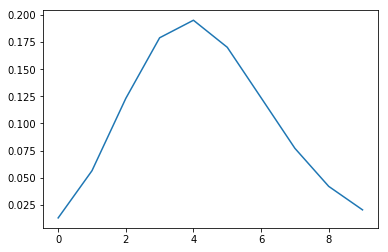

In [312]:
import math 
f= np.random.randn(1)*5
f = np.log(1+np.exp(f))
print(f)
kk = 10
pp = [(k*np.log(f) - f - np.log(math.factorial(k)))[0] for k in range(kk)]
pp = np.exp(pp)
pp = pp/np.sum(pp)
plt.plot(pp)

In [ ]:
end_to_end = True
optimizer='sgd' #Optimizer function
lr=1 #Initial learning rate
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=40 #Number of epoch for learning rate decay

hidden_sizes = [64, 64, 128, 128, 256, 512, 256, 128, 64, 32, 16]#8, 16, 8, 4, 4]
dropouts = [0, 0, .5, .5, .5, .5, .5, .5, .5, 0, 0]#.5, .5, .5]

for kk in range(3):
    single_loss=1.
    multi_loss =0.
    KL = True
    metric = 'ccr'
    for dset_loaders in dset_loaders_arr:
        run_network()

    metric = 'ccr1'
    for dset_loaders in dset_loaders_arr:
        run_network()

    metric = 'mae'
    for dset_loaders in dset_loaders_arr:
        run_network()

    single_loss=0.
    multi_loss =1.
    metric = 'ccr'
    for dset_loaders in dset_loaders_arr:
        run_network()

    metric = 'ccr1'
    for dset_loaders in dset_loaders_arr:
        run_network()

    metric = 'mae'
    for dset_loaders in dset_loaders_arr:
        run_network()


    

In [61]:
end_to_end = True
optimizer='adam' #Optimizer function
lr=0.05 #Initial learning rate
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay


hidden_sizes = [16, 16, 32, 32, 16, 16]#8, 16, 8, 4, 4]
dropouts = []#.5, .5, .5]
single_loss=1.0
multi_loss =0.0

KL = True
metric = None

for lmbda_mae in [.1*k for k in range(11)]:
    multi_coeff = lmbda_mae * np.asarray(make_coeff(nclasses, 'ccr1', coeff_lmbda))
    multi_coeff[int((len(multi_coeff)-1)/2)] = 1.
    for k in range(10):
        run_network()
        
for lmbda_mae in [.1*k for k in range(11)]:
    multi_coeff = lmbda_mae * np.asarray(make_coeff(nclasses, 'mae', coeff_lmbda))
    multi_coeff[int((len(multi_coeff)-1)/2)] = 1.
    for k in range(10):
        run_network()
    
'''KL = True
metric = 'ccr'
for k in range(10):
    run_network()
    
metric = 'ccr1'
for k in range(10):
    run_network()
    
metric = 'mae'
for k in range(10):
    run_network()
    
metric = 'mse'
for k in range(10):
    run_network()'''
    


Algorithm is learn_a
Multi_coef is [ 0.  1.  0.]
Epoch 0/99
----------
LR is set to 0.05
Variable containing:
-2.0074
-0.1140
-0.1974
 0.3888
-0.6736
 0.2404
-1.6391
 0.1642
-0.1674
 0.6457
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]

Variable containing:
 0.1025  0.0933  0.0941  ...   0.0983  0.0927  0.1111
 0.1047  0.0948  0.0944  ...   0.1025  0.0950  0.1072
 0.1021  0.0927  0.0965  ...   0.1045  0.0949  0.1064
          ...             ⋱             ...          
 0.1040  0.0948  0.0939  ...   0.1008  0.0922  0.1090
 0.0991  0.0941  0.0972  ...   0.1027  0.0940  0.1044
 0.1043  0.0955  0.0946  ...   0.1007  0.0952  0.1086
[torch.cuda.FloatTensor of size 256x10 (GPU 0)]

Preds is Variable containing:
-0.3485
-0.3582
-0.3581
-0.3557
-0.3569
-0.3565
-0.3537
-0.3562
-0.3538
-0.3593
-0.3631
-0.3548
-0.3626
-0.3539
-0.3641
-0.3569
-0.3429
-0.3500
-0.3584
-0.3521
-0.3549
-0.3500
-0.3553
-0.3625
-0.3547
-0.3440
-0.3671
-0.3595
-0.3572
-0.3566
-0.3550
-0.3568
-0.3552
-0.3466
-0.3515
-0.35

AttributeError: 'Variable' object has no attribute 'numpy'

# Analysis

Create dataloader again, this time without shuffling

In [ ]:
fvec_norm = (fvec)/5
mid_point = int(len(label)/2)#100*num_classes
fvec_test = fvec_norm[rand_idx[:mid_point],:]
fvec_train = fvec_norm[rand_idx[mid_point:],:]

label_test = label[rand_idx[:mid_point]]
label_train = label[rand_idx[mid_point:]]
print(np.max(fvec_train))
print(np.min(fvec_train))

torch.from_numpy(label_train).type(torch.LongTensor)
dsets={'train': torch.utils.data.TensorDataset(torch.from_numpy(fvec_train).type(torch.FloatTensor),
                                               torch.from_numpy(label_train).type(torch.LongTensor)),
       'val': torch.utils.data.TensorDataset(torch.from_numpy(fvec_test).type(torch.FloatTensor),
                                             torch.from_numpy(label_test).type(torch.LongTensor))}

'''Define dataset loaders'''
dset_loaders = {'train':torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size,shuffle=False,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dsets['val'], batch_size=batch_size,shuffle=False,
                                                    num_workers=12)}

In [ ]:
import os

data_shape = 'Spiral'
data_date = '18_01_31'
data_dir = './saved_models_github/' + data_shape + '/' + data_date

run_dirs = sorted(os.listdir(data_dir))
last_dirs = run_dirs[1::2]
ccr1_dirs = last_dirs[:110]
mae_dirs = last_dirs[110:]
all_dirs = [ccr1_dirs, mae_dirs]


'''run_dirs = sorted(os.listdir('./saved_models/test'))
last_dirs = run_dirs[1::2]
ccr1_dirs = last_dirs[:100]
mae_dirs = last_dirs[100:]

pure_ccr1 = ['Ordinal_January24  14:10:01_last',
             'Ordinal_January24  14:11:08_last',
             'Ordinal_January24  14:12:14_last',
             'Ordinal_January24  14:13:21_last',
             'Ordinal_January24  14:14:27_last',
             'Ordinal_January24  14:15:34_last',
             'Ordinal_January24  14:16:40_last',
             'Ordinal_January24  14:17:47_last',
             'Ordinal_January24  14:18:54_last',
             'Ordinal_January24  14:20:00_last',]

pure_mae = ['Ordinal_January24  14:21:07_last',
             'Ordinal_January24  14:22:13_last',
             'Ordinal_January24  14:23:19_last',
             'Ordinal_January24  14:24:26_last',
             'Ordinal_January24  14:25:32_last',
             'Ordinal_January24  14:26:38_last',
             'Ordinal_January24  14:27:45_last',
             'Ordinal_January24  14:28:52_last',
             'Ordinal_January24  14:29:58_last',
             'Ordinal_January24  14:31:05_last',]'''
                
len(mae_dirs)

In [ ]:
torch.load('./saved_models/ord/Ordinal_January24  10:24:20_last', map_location={'cuda:0': 'cpu'})


In [ ]:
def validate(model_dir, phase='train'):
    if use_gpu:
        model = torch.load(model_dir)
    else:
        model = torch.load(model_dir, map_location={'cuda:0': 'cpu'})
    model.train(False)

    labels_arr = np.asarray([]);
    preds_arr = np.asarray([]);
    for data in dset_loaders[phase]:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            outputs = np.argmax(model(inputs).cpu().data.numpy(), axis=1)
            #labels_arr = np.append(labels_arr,labels.cpu().data.numpy())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = np.argmax(model(inputs).data.numpy(), axis=1)
            #labels_arr = np.append(labels_arr,labels.data.numpy())
          
        preds_arr = np.append(preds_arr, outputs)
    return preds_arr
#pred_tr = validate('./saved_models/ord/Ordinal_January24  10:24:20_last')
#print(np.min(label_train))

In [ ]:

plt.figure(figsize=(18,15))

for k in range(5):
    plt.subplot(3,5,k+1)
    pred_tr = validate(data_dir + '/' + last_dirs[k])
    plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
    #plt.scatter(fvec_train[:, 0], fvec_train[:, 1], c=label_train,vmin=-1, vmax=num_classes)
    plt.colorbar()
    ccr = np.mean(pred_tr==label_train)
    ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
    mae = np.mean(np.abs(pred_tr-label_train))
    rmse = np.mean((pred_tr-label_train)**2)
    plt.title('$CCR$ loss' + 
              ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
              ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)))
    
for k in range(5):
    plt.subplot(3,5,k+6)
    pred_tr = validate(data_dir + '/' + last_dirs[50+k])
    plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
    #plt.scatter(fvec_train[:, 0], fvec_train[:, 1], c=label_train,vmin=-1, vmax=num_classes)
    plt.colorbar()
    ccr = np.mean(pred_tr==label_train)
    ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
    mae = np.mean(np.abs(pred_tr-label_train))
    rmse = np.mean((pred_tr-label_train)**2)
    plt.title('$0.5CCR$ loss + $0.5CCR_1$ loss \n' + 
              ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
              ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)))
    
for k in range(5):
    plt.subplot(3,5,k+11)
    pred_tr = validate(data_dir + '/' + last_dirs[100+k])
    plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
    #plt.scatter(fvec_train[:, 0], fvec_train[:, 1], c=label_train,vmin=-1, vmax=num_classes)
    plt.colorbar()
    ccr = np.mean(pred_tr==label_train)
    ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
    mae = np.mean(np.abs(pred_tr-label_train))
    rmse = np.mean((pred_tr-label_train)**2)
    plt.title('$CCR_1$ loss ' + 
              ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
              ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)))
    
plt.savefig('variance_of_results.tiff')

In [ ]:
def validate_and_mean(root_dir, sub_dirs, phase='train'):
    scores_arr = np.zeros((label_train.shape[0],9))
    for sub_dir in sub_dirs:
        if use_gpu:
            model = torch.load(root_dir + '/' + sub_dir)
        else:
            model = torch.load(root_dir + '/' + sub_dir, map_location={'cuda:0': 'cpu'})
        model.train(False)
        #print(model)
        score_arr = np.zeros((1,9))
        for data in dset_loaders[phase]:
            inputs, labels = data
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                outputs = model(inputs).cpu().data.numpy()
                #print(outputs.shape)
            else:
                inputs, labels = Variable(inputs), Variable(labels)
                outputs = model(inputs).data.numpy()
                
            score_arr = np.append(score_arr, outputs, axis=0)
        scores_arr += score_arr[1:,:]
        
    return scores_arr
#scores_tr = validate_and_mean('./saved_models/test_circular', last_dirs[:10])
#pred_tr = np.argmax(scores_tr, axis=1)
#print(np.mean(label_train == pred_tr))

In [ ]:
model_dirs = ['./saved_models/ord/Ordinal_January24  10:16:00_last',
             './saved_models/ord/Ordinal_January24  10:20:35_last',
             './saved_models/ord/Ordinal_January24  10:24:20_last',
             './saved_models/ord/Ordinal_January24  10:28:03_last']

'''model_dirs = ['./saved_models/ord/Ordinal_January24  13:09:17_last',
             './saved_models/ord/Ordinal_January24  13:18:08_last',
             './saved_models/ord/Ordinal_January24  13:27:43_last',
             './saved_models/ord/Ordinal_January24  13:43:43_last']'''

model_dirs = ['./saved_models/ord/Ordinal_January26  00:22:14_last',
              './saved_models/ord/Ordinal_January26  00:19:20_last',
              './saved_models/ord/Ordinal_January26  00:09:08_last',
              './saved_models/ord/Ordinal_January26  00:17:53_last']
preds = []

for model_dir in model_dirs:
    preds.append(validate(model_dir))
    
print(len(preds))

In [ ]:
metric = 'CCR1'

if metric is 'CCR1':
    metric_code = 0
elif metric is 'MAE':
    metric_code = 1
else:
    print('Wrong metric')
    
plt.figure(figsize=(20,15))

plt.subplot(4,3,1)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=label_train, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
plt.title('Ground Truth')

metrics = np.zeros((11, 4))
for k in range(10):
    scores_tr = validate_and_mean(data_dir, all_dirs[metric_code][k*10:(k+1)*10])
    pred_tr = np.argmax(scores_tr, axis=1)
    plt.subplot(4,3,k+2)
    plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
    plt.colorbar()
    ccr = np.mean(pred_tr==label_train)
    ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
    mae = np.mean(np.abs(pred_tr-label_train))
    rmse = np.mean((pred_tr-label_train)**2)
    metrics[k,:] = [ccr,ccr1,mae,rmse]
    plt.title('$\lambda$=' + str(np.round(k*.1, decimals=1)) + 
              ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
              ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
              ', $MAE$=' + str(np.round(mae, decimals = 2)) +
              ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

    
#pred_tr = validate('./saved_models/ord/Ordinal_January24  10:20:35_last')
#pred_tr = validate('./saved_models/ord/Ordinal_January24  13:18:08_last')

scores_tr = validate_and_mean(data_dir, all_dirs[metric_code][100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(4,3,12)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
metrics[10,:] = [ccr,ccr1,mae,rmse]
plt.title('$\lambda$=1.0' + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ', $MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

plt_title = data_shape + '_Data_CCR_' + metric + '_tradeoff_' + data_date + '.tiff'
plt.savefig(plt_title)

In [ ]:
print(metrics)

lmbdas = [.1*k for k in range(11)]

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.plot(lmbdas, metrics[:,0], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$CCR$')

plt.subplot(222)
plt.plot(lmbdas, metrics[:,1], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$CCR_1$')

plt.subplot(223)
plt.plot(lmbdas, metrics[:,2], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$MAE$')

plt.subplot(224)
plt.plot(lmbdas, metrics[:,3], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$RMSE$')

plt.savefig('spiral_plots_ccr1.tiff')

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=label_train, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
plt.title('Ground Truth')

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[:10])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,2)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
plt.title('$CCR loss$'  + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ',\n $MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,3)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
plt.title('$CCR_1 loss$'  + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ',\n $MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

scores_tr = validate_and_mean('./saved_models/ord', mae_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,4)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
plt.title('$MAE loss$'  + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ',\n$MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

plt.savefig('spiral_extreme.tiff')

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=label_train, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
plt.title('Ground Truth')

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[:10])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,2)
plt.hist(pred_tr-label_train, bins = np.arange(-4.5,5.5,1))
plt.title('$CCR$ loss')

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,3)
plt.hist(pred_tr-label_train, bins = np.arange(-4.5,5.5,1))
plt.title('$CCR_1$ loss')

scores_tr = validate_and_mean('./saved_models/test_circular', mae_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,4)
plt.hist(pred_tr-label_train, bins = np.arange(-4.5,5.5,1))
plt.title('$MAE$ loss')

plt.savefig('circular_extreme_hist.tiff')

In [ ]:
import matplotlib.image as mpimg

plt.figure(figsize=(18, 10))
plt.subplot(211)
img = mpimg.imread('Circular_Data_Extreme_Weights.eps')
plt.imshow(img)
plt.subplot(212)
img = mpimg.imread('Spiral_Data_Extreme_Weights.eps')
plt.imshow(img)